# Importing packages

In [1]:
from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Conv2D,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import  Model
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, cv2
import random
import PIL
import scipy

# Creating data

In [2]:
data_path='D:/Work/Jadavpur_university/Research/train_set'
list_folder=os.listdir(path = data_path)
data=[]
im_size=240    
for i in list_folder:
    new_path=os.path.join(data_path,i) 
    pic_list=os.listdir(new_path)                                               
    for img in pic_list:
        pic=os.path.join(new_path,img)   
        arr=cv2.imread(pic)    
        data.append([arr,list_folder.index(i)])    
        
random.shuffle(data)  
x_train,y_train=[],[]
for i,j in data:
    x_train.append(i)
    y_train.append(j)
x_train=np.array(x_train).reshape(-1,im_size,im_size,3)
y_train=np.array(y_train).reshape(-1,1)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train)
X_train = x_train/255
y_train = y_train.toarray()


X_train, X_test, Y_train, Y_test = train_test_split(X_train,y_train, test_size=0.25)


print('Dimension of training and testing images :', X_train.shape[1:3])
print('Number of training set images : ', X_train.shape[0])
print('Number of testing set images : ', X_test.shape[0])

Dimension of training and testing images : (240, 240)
Number of training set images :  721
Number of testing set images :  241


# Importing pre-trained model

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(input_shape = (240,240,3),
              include_top = False,
              weights = None)

weights = 'D:/Work/Jadavpur_University/Research/weights/vgg16.h5'
model.load_weights(weights)

for layer in model.layers:
    layer.trainable = False
    
last_layer = model.get_layer('block5_conv3')
last = last_layer.output

print('Last layer shape:', last.shape)



Last layer shape: (None, 15, 15, 512)


# Adding our model

In [13]:
x = Conv2D(400, (1,1), activation = 'relu', input_shape = last.shape[1:])(last)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(4, activation = 'softmax')(x)

classifier = Model(inputs = model.input, outputs = x)
opt1 = Adam(learning_rate = 0.002)
opt2 = RMSprop(learning_rate = 0.001)
classifier.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0   

## Training the model

In [14]:
history = classifier.fit(X_train, Y_train, batch_size = 10, epochs = 20, shuffle = True, validation_data=(X_test, Y_test))

Train on 721 samples, validate on 241 samples
Epoch 1/20
721/721 [==============================] - 34s 48ms/sample - loss: 1.6983 - accuracy: 0.6325 - val_loss: 0.5147 - val_accuracy: 0.7759
Epoch 2/20
721/721 [==============================] - 33s 46ms/sample - loss: 0.3960 - accuracy: 0.8571 - val_loss: 0.2777 - val_accuracy: 0.9046
Epoch 3/20
721/721 [==============================] - 33s 46ms/sample - loss: 0.2298 - accuracy: 0.9223 - val_loss: 0.1963 - val_accuracy: 0.9212
Epoch 4/20
721/721 [==============================] - 33s 46ms/sample - loss: 0.1640 - accuracy: 0.9320 - val_loss: 0.1609 - val_accuracy: 0.9461
Epoch 5/20
721/721 [==============================] - 33s 46ms/sample - loss: 0.0975 - accuracy: 0.9626 - val_loss: 0.2043 - val_accuracy: 0.9461
Epoch 6/20
721/721 [==============================] - 34s 47ms/sample - loss: 0.1151 - accuracy: 0.9612 - val_loss: 0.2559 - val_accuracy: 0.9253
Epoch 7/20
721/721 [==============================] - 34s 47ms/sample - loss: 

# Visualizing the loss and accuracy

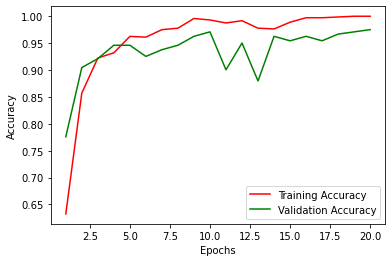

In [15]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculating the F1 Score

### Getting the actual targets and the predicted results

In [16]:
classifier.save('brain_vgg16_final.h5')
preds = classifier.predict(X_test)
actual = []
predictions = []
for i in range(len(preds)):
    actual.append(np.argmax(Y_test[i]))
    predictions.append(np.argmax(preds[i]))

### Getting the data for evaluation of precision, recall and F1 score

In [17]:
a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4 = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
for j in range(len(actual)):
    if actual[j] == 0:
        if predictions[j] == 0:
            a1 += 1
        elif predictions[j] == 1:
            a2 += 1
        elif predictions[j] == 2:
            a3 += 1
        else:
            a4 += 1
    elif actual[j] == 1:
        if predictions[j] == 0:
            b1 += 1
        elif predictions[j] == 1:
            b2 += 1
        elif predictions[j] == 2:
            b3 += 1
        else:
            b4 += 1
    elif actual[j] == 2:
        if predictions[j] == 0:
            c1 += 1
        elif predictions[j] == 1:
            c2 += 1
        elif predictions[j] == 2:
            c3 += 1
        else:
            c4 += 1
    elif actual[j] == 3:
        if predictions[j] == 0:
            d1 += 1
        elif predictions[j] == 1:
            d2 += 1
        elif predictions[j] == 2:
            d3 += 1
        else:
            d4 += 1
            
            

In [18]:
def h_mean(x,y):
    return (2*(x*y)/(x+y))

### Finding recall, precision and F1 score for each class

In [19]:
#flair
tpf = a1
fpf = b1+c1+d1
fnf = a2+a3+a4
precision_flair = tpf/(tpf + fpf)
recall_flair = tpf/(tpf+fnf)
try:
    F1_flair = h_mean(precision_flair, recall_flair)
    print('The F1 score for flair class is :', F1_flair)
except:
    print('Sorry division by zero')

#t1
tpt1 = b2
fpt1 = a2+c2+d2
fnt1 = b1+b3+b4
precision_t1 = tpt1/(tpt1 + fpt1)
recall_t1 = tpt1/(tpt1+fnt1)
try:
    F1_t1 = h_mean(precision_t1, recall_t1)
    print('The F1 score for t1 class is :', F1_t1)
except:
    print('Sorry division by zero')

#t1ce
tpt1ce = c3
fpt1ce = a3+b3+d3
fnt1ce = c1+c2+c4
try:
    precision_t1ce = tpt1ce/(tpt1ce + fpt1ce)
    recall_t1ce = tpt1ce/(tpt1ce+fnt1ce)
    F1_t1ce = h_mean(precision_t1ce, recall_t1ce)
    print('The F1 score for t1ce class is :', F1_t1ce)
except:
    print('Sorry division by zero, therefore = 0')
    
    
#t2
tpt2 = d4
fpt2 = a4+b4+c4
fnt2 = d1+d2+d3
try:
    precision_t2 = tpt2/(tpt2 + fpt2)
    recall_t2 = tpt2/(tpt2+fnt2)
    F1_t2 = h_mean(precision_t2, recall_t2)
    print('The F1 score for t2 class is :', F1_t2)
except:
    print('Sorry division by zero')
    
    
    
print('\nAverage F1 score is: ', (F1_flair+F1_t1+F1_t1ce+F1_t2)/4)

The F1 score for flair class is : 0.9734513274336283
The F1 score for t1 class is : 0.9661016949152542
The F1 score for t1ce class is : 0.9586776859504132
The F1 score for t2 class is : 1.0

Average F1 score is:  0.9745576770748239


# Confusion matrix

In [20]:
table = [[a1,b1,c1,d1], [a2,b2,c2,d2], [a3,b3,c3,d3], [a4,b4,c4,d4]]
table = np.array(table)
confusion_matrix = pd.DataFrame(data = table, index = ['flair', 't1', 't1ce', 't2'], columns = ['flair', 't1', 't1ce', 't2'] )
confusion_matrix

,flair,t1,t1ce,t2
flair,55,1,2,0
t1,0,57,3,0
t1ce,0,0,58,0
t2,0,0,0,65


# K-folds cross validation

In [21]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def build_classifier():
    x = Conv2D(200, (1,1), activation = 'relu', input_shape = last.shape[1:])(last)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(rate = 0.25)(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(rate = 0.25)(x)
    x = Dense(4, activation = 'softmax')(x)

    classifier = Model(inputs = model.input, outputs = x)
    opt1 = Adam(learning_rate = 0.001)
    opt2 = RMSprop(learning_rate = 0.001)
    classifier.compile(optimizer = opt2 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

Using TensorFlow backend.


In [22]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 15)

In [23]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = Y_train, cv = 6)

mean = accuracies.mean()
variance = accuracies.std()

Train on 600 samples
Epoch 1/15
600/600 [==============================] - 22s 36ms/sample - loss: 2.3609 - accuracy: 0.5367
Epoch 2/15
600/600 [==============================] - 21s 35ms/sample - loss: 0.4496 - accuracy: 0.8233
Epoch 3/15
600/600 [==============================] - 21s 35ms/sample - loss: 0.2661 - accuracy: 0.8983
Epoch 4/15
600/600 [==============================] - 21s 35ms/sample - loss: 0.1762 - accuracy: 0.9433
Epoch 5/15
600/600 [==============================] - 21s 35ms/sample - loss: 0.1437 - accuracy: 0.9650
Epoch 6/15
600/600 [==============================] - 21s 35ms/sample - loss: 0.1112 - accuracy: 0.9683
Epoch 7/15
600/600 [==============================] - 21s 35ms/sample - loss: 0.0483 - accuracy: 0.9867
Epoch 8/15
600/600 [==============================] - 21s 36ms/sample - loss: 0.0554 - accuracy: 0.9833
Epoch 9/15
600/600 [==============================] - 22s 36ms/sample - loss: 0.0354 - accuracy: 0.9900
Epoch 10/15
600/600 [======================

601/601 [==============================] - 22s 36ms/sample - loss: 0.0340 - accuracy: 0.9967
Epoch 15/15
120/120 [==============================] - 4s 37ms/sample - loss: 0.4979 - accuracy: 0.9583
Train on 601 samples
Epoch 1/15
601/601 [==============================] - 23s 39ms/sample - loss: 2.5387 - accuracy: 0.4925
Epoch 2/15
601/601 [==============================] - 22s 36ms/sample - loss: 0.4206 - accuracy: 0.8369
Epoch 3/15
601/601 [==============================] - 22s 36ms/sample - loss: 0.2462 - accuracy: 0.9285
Epoch 4/15
601/601 [==============================] - 22s 36ms/sample - loss: 0.1842 - accuracy: 0.9434
Epoch 5/15
601/601 [==============================] - 23s 38ms/sample - loss: 0.0820 - accuracy: 0.9700
Epoch 6/15
601/601 [==============================] - 24s 40ms/sample - loss: 0.0583 - accuracy: 0.9734
Epoch 7/15
601/601 [==============================] - 22s 37ms/sample - loss: 0.0849 - accuracy: 0.9834
Epoch 8/15
601/601 [==============================] - 

In [24]:
accuracy = pd.DataFrame(data = accuracies, index = list(range(1,7)), columns = ['Accuracy'])
print('The AVERAGE accuracy after the cross validation is : ', mean)
print('The VARIANCE of the accuracy after the cross validation is : ', variance)
print('\nThe accuracies for the cross validation are :\n')
accuracy

The AVERAGE accuracy after the cross validation is :  0.9292929271856943
The VARIANCE of the accuracy after the cross validation is :  0.025696841856770312

The accuracies for the cross validation are :



,Accuracy
1,0.909091
2,0.883333
3,0.941667
4,0.950000
5,0.958333
6,0.933333
